In [123]:
# import
import torch
from torch import nn, optim
from torch.nn.utils import prune
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import to_pil_image

import matplotlib.pyplot as plt

In [124]:
# load dataset
'''transform 적용해보기'''
d_tr = datasets.CIFAR10(root='./data', download=True, train=True, transform=ToTensor())
d_ts = datasets.CIFAR10(root='./data', download=True, train=False, transform=ToTensor())

# ToTensor : ndarray(or PIL) -> Tensor

#       (H, W, C) -> (C, H, W)
#       (0 ~ 255) -> (0 ~ 1)

Files already downloaded and verified
Files already downloaded and verified


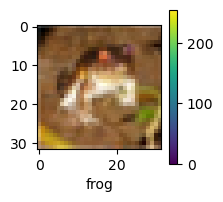

In [125]:
# data check
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
idx = 0
x, y = d_tr[idx]
x = to_pil_image(x) # Tensor -> PIL

plt.figure(figsize=(2,2))
plt.imshow(x)
plt.colorbar()
plt.xlabel(class_names[y])
plt.show()

In [126]:
# GPU device
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu') # 확실히 mps더 몇십배는 더 빠름

In [127]:
# model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(in_features=2048, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.droput = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.droput(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.droput(x)
        x = self.relu(self.conv3(x))
        x = self.droput(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.droput(x)
        x = self.fc2(x)
        return x
'''
    입력    (1, 3, 32, 32)          = (batch, channels, H, W)
    합성곱  -> (1, 32, 30, 30)      필터 (32, 3, 3, 3) = (out_ch, in_ch, H, W)
    풀링    -> (1, 32, 15, 15)

    합성곱  -> (1, 64, 13, 13)      필터 (64, 32, 3, 3)
    풀링    -> (1, 64, 6, 6)        왜 7,7이 아니라 6,6 일까? 남는 값은 버리나?

    합성곱  -> (1, 128, 4, 4)        필터 (128, 64, 3, 3)
    평탄화  -> (1, 2048)
    밀집층  -> (1, 256)
    밀집층  -> (1, 10)
'''

'\n    입력    (1, 3, 32, 32)          = (batch, channels, H, W)\n    합성곱  -> (1, 32, 30, 30)      필터 (32, 3, 3, 3) = (out_ch, in_ch, H, W)\n    풀링    -> (1, 32, 15, 15)\n\n    합성곱  -> (1, 64, 13, 13)      필터 (64, 32, 3, 3)\n    풀링    -> (1, 64, 6, 6)        왜 7,7이 아니라 6,6 일까? 남는 값은 버리나?\n\n    합성곱  -> (1, 128, 4, 4)        필터 (128, 64, 3, 3)\n    평탄화  -> (1, 2048)\n    밀집층  -> (1, 256)\n    밀집층  -> (1, 10)\n'

In [128]:
# train loop
def train(dataloader, model, loss_fn, optimizer):
    batch_size = dataloader.batch_size
    num_batches = len(dataloader)
    loss_tr = 0
    acc_tr = 0

    model.train() # 훈련모드
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # 순전파
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        
        loss_tr += loss.item()  # item(): tensor 값 추출
        acc_tr += (y_pred.argmax(1) == y).sum().item() / batch_size

        # 역전파
        loss.backward()         # 역전파
        optimizer.step()        # 가중치 조정
        optimizer.zero_grad()   # gradient 초기화 (안하면 중첩됨)

    loss_tr /= num_batches
    acc_tr /= num_batches
    print(f'Tr loss: {loss_tr:>6f}, acc: {acc_tr:>4f}')

    return loss_tr, acc_tr

In [129]:
# test loop
def test(dataloader, model, loss_fn):
    batch_size = dataloader.batch_size
    num_batches = len(dataloader)
    loss_ts = 0
    acc_ts = 0
    
    model.eval() # 평가모드
    with torch.no_grad():           # 평가시, gradient 계산하지 않도록
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # 순전파
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            loss_ts += loss.item()
            acc_ts += (y_pred.argmax(1) == y).sum().item() / batch_size

    loss_ts /= num_batches
    acc_ts /= num_batches
    print(f"Ts loss: {loss_ts:>6f}, acc: {acc_ts:>4f}")

    return loss_ts, acc_ts

In [130]:
# weight initialization
def init_weights(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight)

In [120]:
# weight prunning
def prune_weights(module, amount):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        prune.l1_unstructured(module, 'weight', amount=amount)

# weight remove pruning
def unprune_weighs(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        if hasattr(module, 'weight_orig'):  # pruning이 적용된 경우만 존재하는 속성
            prune.remove(module, 'weight')

In [137]:
# model init
model = CNN()
model = model.to(device)
model.apply(init_weights)
model.apply(unprune_weighs)

#####################################################
# hyper parameter
lr = 2e-4
batch_size = 128
epochs = 200

prune_term = 150
prune_rate = 0.2

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
#####################################################

# dataloader
dl_tr = DataLoader(d_tr, batch_size=batch_size, shuffle=True, pin_memory=True) # pin_memory, pin_memory_device : gpu로드 속도를 높인다는데 어렵다.. 없는게 더 빠르다
dl_ts = DataLoader(d_ts, batch_size=batch_size, shuffle=True, pin_memory=True)

In [138]:
# train/test
tr_losses = []
ts_losses = []
ts_accs = []
tr_accs = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    tr_loss, tr_acc = train(dl_tr, model, loss_fn, optimizer)
    ts_loss, ts_acc = test(dl_ts, model, loss_fn)
    
    tr_losses.append(tr_loss)
    ts_losses.append(ts_loss)
    tr_accs.append(tr_acc)
    ts_accs.append(ts_acc)

    if epoch % prune_term == 0:
        model.apply(lambda m : prune_weights(m, amount=prune_rate))

    print('-------------------------------')
print("Done!")

Epoch 1
Tr loss: 2.090835, acc: 0.231278
Ts loss: 1.820783, acc: 0.349881
-------------------------------
Epoch 2
Tr loss: 1.717887, acc: 0.370944
Ts loss: 1.650004, acc: 0.429292
-------------------------------
Epoch 3
Tr loss: 1.567676, acc: 0.429088
Ts loss: 1.540670, acc: 0.473695
-------------------------------
Epoch 4
Tr loss: 1.479201, acc: 0.462096
Ts loss: 1.439053, acc: 0.509494
-------------------------------
Epoch 5


KeyboardInterrupt: 

# 01
lr = 28e-5 / batch_size = 256 / epochs = 300
prune_term = 50 / prune_rate = 30

## lr
그래프 상으로 lr이 크다.. 처음에 감소세가 너무 가파름
-> 23r-5

## prun 
50은 너무 좁다.. 최적화가 되기도 전에 prun 하는듯 
이거 때문에 성능이 계속 떨어지나?? 정확도가 점점 떨어짐 // 하지만 train/test acc가 차이나지 않고 함께 떨어지고 있으니 과적합은 아니다.
-> 100 (점점 prun rate 낮아지게)

## epoch
에폭 90에 71 돌입,, 이후로 71~73 왔다갔다.
-> 그래도 00

## regularization
너무 심한듯.. train/test가 너무 동일하게 작아짐.. (dropout 3번, 30%)
-> drop out (3번 20%)

# 02
lr = 23e-5
batch_size = 256
epochs = 300
prune_term = 100
prune_rate = 0.3
dropout = 0.2  (3번)

## lr
그래프가 과적합
-> 2e-4

## batch
좀 줄여도 될듯?
-> 128

## epoch
90 이후로 진전이 거의 없음
-> layer 변경 (conv3 (64 -> 128), fc2 ((1024, 64) -> (2048, 256))) / epoch 늘리기

## prune
150마다, 0.2 (prune은 경량화지, 성능 향상과는 조오금 무관)

## drop out (normalizaion)
정규화가 조금 덜됨. train/test acc 차이 발생, 좀만 더 늘리자
-> 20% (4개)

## 방안, 성능이 정체되어 수렴하면, 에폭을 줄이지 말고 정규화 + 모델구조변경/lr높이기

# 03
lr = 2e-4
batch_size = 128
epochs = 400
prune_term = 150
prune_rate = 0.3

In [113]:
# prune rate
prune_num = 0
total_num = 0

for _, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        prune_num += torch.sum(module.weight == 0)
        total_num += module.weight.nelement()

print(prune_num.item())
print(f'sparsity: {(prune_num / total_num) * 100:.2f}%')

80375
sparsity: 65.70%


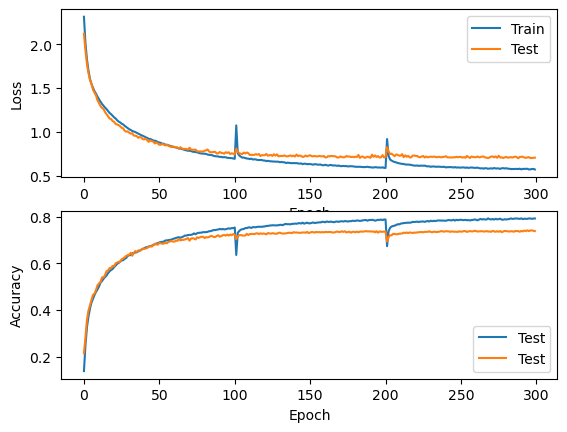

In [115]:
# plot by epoch
fig, ax = plt.subplots(2,1)

# loss
ax[0].plot(tr_losses, label='Train')
ax[0].plot(ts_losses, label='Test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# acc
ax[1].plot(tr_accs, label='Test')
ax[1].plot(ts_accs, label='Test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

## 성능향상하기

1. 변경 사항들을 모델 구성에 적용하여 다양한 하이퍼파라미터 조합의 실험을 진행할 수 있습니다.

2. 실험을 통해 각 하이퍼파라미터가 모델 성능에 미치는 영향을 분석하는 것이 중요합니다. (즉, 여러번 실험해야 함)


        1. 학습률 (Learning Rate)
        - 낮은 학습률: 모델이 최적점에 도달하는데 더 오래 걸릴 수 있습니다. 하지만 너무 낮으면 학습이 충분히 진행되지 않을 수 있습니다.
        - 높은 학습률: 학습이 빠르게 진행되지만, 너무 높으면 최적점을 지나쳐 발산할 수 있습니다. 즉, 모델이 수렴하지 못하고 성능이 저하될 수 있습니다.


        2. 배치 크기 (Batch Size)
        - 작은 배치 크기: 더 자주 업데이트되어 학습이 빨라질 수 있지만, 불안정한 학습 경향을 보일 수 있습니다. 또한 과적합의 위험이 높아질 수 있습니다.
        - 큰 배치 크기: 메모리 사용량이 증가하고, 학습 시간이 감소할 수 있지만, 일반화 성능이 저하될 수 있습니다.


        3. 에포크 수 (Number of Epochs)
        - 적은 에포크 수: 모델이 충분히 학습되지 않아 성능이 낮을 수 있습니다.
        - 많은 에포크 수: 모델이 더 잘 학습되지만, 너무 많으면 과적합(모델이 훈련 데이터에 지나치게 최적화되어 새로운 데이터에서 성능이 저하됨)의 위험이 있습니다.


        4. 은닉층의 뉴런 수 (Number of Neurons in Hidden Layers)
        - 적은 뉴런 수: 모델이 데이터의 복잡성을 충분히 포착하지 못할 수 있습니다. 즉, 모델의 용량이 낮아져 학습이 제한될 수 있습니다.
        - 많은 뉴런 수: 모델이 더 복잡한 패턴을 학습할 수 있지만, 계산 비용이 증가하고 과적합의 위험이 높아질 수 있습니다.


        5. 드롭아웃 비율 (Dropout Rate)
        - 낮은 드롭아웃 비율: 드롭아웃의 효과가 미미할 수 있으며, 과적합의 위험이 존재합니다.
        - 높은 드롭아웃 비율: 과적합을 방지할 수 있지만, 너무 높으면 네트워크가 데이터의 중요한 패턴을 학습하는 데 방해가 될 수 있습니다.